Amazonのレビューのデータセットを用いて、

レビューの文章→レーティング(5段階評価)を予測するモデルを作成しました。

githubで学習済みモデルを提供していますが、

新たに学習したい場合は、以下の retrain_mode を True にしてください。

最初の実行では必ず retrain_mode = True にして、モデルを作成してください。

In [1]:
retrain_mode = True

ログの出力を wandb を用いて行っています。

以下の設定で切り替え可能です。

In [2]:
import os

wandb_disabled = "true" # 文字列で渡す
os.environ["WANDB_DISABLED"] = wandb_disabled

In [3]:
%%capture
!git clone https://github.com/shogoromal/AmazonRating_T5.git
_colab_dir_ = "AmazonRating_T5"

# 開発用
"""
from google.colab import drive
drive.mount('/content/drive')
_colab_dir_ = "/content/drive/MyDrive/Colab Notebooks/20240608_AmazonRating_T5"
"""

os.chdir(_colab_dir_)

'\n%%capture\n!git clone https://github.com/shogoromal/AmazonRating_T5.git\nchdir = "AmazonRating_T5"\n'

Mounted at /content/drive


In [5]:
%%capture
!pip install datasets
!pip install transformers
!pip install accelerate -U
!pip install torch torchvision
!pip install tensorboard

In [6]:
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from datasets import load_dataset

from utils import rating_num_check

#データの準備

データをダウンロードする。

In [7]:
raw_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

All_Beauty.jsonl:   0%|          | 0.00/327M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

helpful_vote (= いわゆる「役に立った」) が3以上のデータを抽出する。

In [8]:
extracted_dataset = raw_dataset['full'].filter(lambda x: x['helpful_vote'] >= 3)

Filter:   0%|          | 0/701528 [00:00<?, ? examples/s]

あらためて、データの数を表示。
星5 のデータの数が多いなど、偏りがあることが分かる。

[8721, 2946, 3803, 6356, 32546]


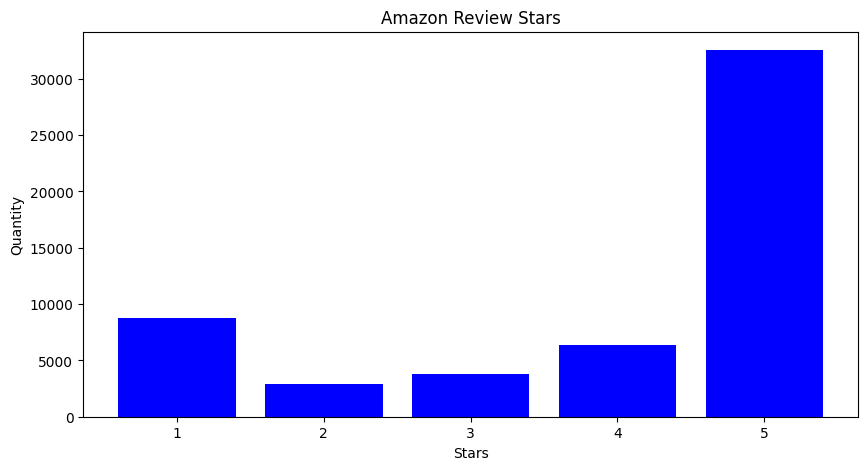

In [9]:
rating_num_check(extracted_dataset)

データの中身を例として表示。
このうち、rating, text のデータを使う。

In [10]:
extracted_dataset[0]

{'rating': 5.0,
 'title': 'You won’t regret this purchase.',
 'text': 'Got my new eyebrows in mail today.  Magically my baby caterpillars grew into gorgeous mama size ones.  Papa caterpillar loved the look.  And the eyebrow pen, tweezers and brow shaper templates were just an extra nice bonus!  Thank you.',
 'images': [],
 'asin': 'B07ZJKVVLW',
 'parent_asin': 'B07ZJKVVLW',
 'user_id': 'AHPUT3ITXCHQJO7OMF74LEMYHIVA',
 'timestamp': 1578611984772,
 'helpful_vote': 430,
 'verified_purchase': True}

ratingに対して、どのようなラベルを付与するかを決定する。

T5 モデルはレーティングの数値そのものを解釈できないので、言語に変換する。

In [11]:
#数字の評価を単語に変換する
rating_sentence = \
    {
        1: "Very Poor",
        2: "Poor",
        3: "Average",
        4: "Good",
        5: "Excellent"
    }

各レートからデータを取り出す

指示文を作成する



In [12]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/content/drive/MyDrive/Colab Notebooks/20240608_AmazonRating_T5/utils.py'>

データセットから各レーティングごとに等しい数のサンプルを抽出。

指示用の文章 (モデルへのinput) を作成する。

preset のモデルは seed 値 4 でコードを実行して学数したものです。これ以外の値で指示文を作成した場合、学習時と指示文が異なることになります。

In [13]:
# データセットをロードするコードが必要です（ここでは省略）
# データ抽出とフォーマットされたテキストの生成
#メモリがギリなので各レートのサンプル数を1に変更する

from utils import extract_and_format_samples

bos_instruction, dataset = extract_and_format_samples(extracted_dataset, rating_sentence, max_samples_per_rating = 800, ex_samples_per_rating = 1, seed = 4)

Filter:   0%|          | 0/54372 [00:00<?, ? examples/s]

Filter:   0%|          | 0/54372 [00:00<?, ? examples/s]

Filter:   0%|          | 0/54372 [00:00<?, ? examples/s]

Filter:   0%|          | 0/54372 [00:00<?, ? examples/s]

Filter:   0%|          | 0/54372 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

モデルに渡すための指示文を表示する

In [14]:
#指示文を表示する
print(bos_instruction)


Definition : The output will be 5 rank rating (output),
which is Very Poor, Poor, Average, Good or Excellent.
These rating is belong the sentence (input) to explain the rating.
example1:
input: This is a literal piece of garbage. It has no sharp edges to actually remove anything and it’s just vibrates like a cheap toothbrush. Even the “scaler” that comes with it is a joke, again no sharp edges to scrape anything. Save your money and get an actual scaler. This thing is a joke.
output: Very Poor
example2:
input: WARNING! This product is advertised as being a thermal heat protection spray. It is not, it completely damaged my hair!!!! I had to go back to salon literally the month after I just got it cut because the ends were fried to the max, even my hairdresser was mortified as to what damaged my hair. I had to pay a pretty penny for a deep conditioning salon treatment to get my hair back to normal.<br /><br />Also, it smells really bad though if it actually worked I won't mind it as muc

In [15]:
# データセットをトレーニングデータとテストデータに分ける
train_test_split = dataset.train_test_split(test_size=0.2)  # 20%をテストデータに設定

# 分割されたデータセットを取得
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# 分割後のデータセットの概要を表示
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 3200
Test dataset size: 800


In [16]:
#読み込んだデータは削除しておく
del raw_dataset
del extracted_dataset
del dataset
del train_test_split
import gc
gc.collect()

105

#モデルを作成する

In [17]:
from torch.utils.tensorboard import SummaryWriter
Writer = SummaryWriter()

In [18]:
try:
    use_mps = True if torch.has_mps else False
except:
    use_mps = False

<ipython-input-18-4ba4dfce130e>:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  use_mps = True if torch.has_mps else False


細かいトレーニングの設定

In [19]:
from models import Config

args = {
    'model': 'train',
    'model_checkpoint': 'allenai/tk-instruct-base-def-pos',#論文におけるベースモデルと同じ
    'evaluation_strategy': 'no',
    'task': 'AmazonRating',
    'output_dir': './model_output',
    'save_strategy':'steps',
    'save_steps':1000,
    'learning_rate': 2e-4,
    'num_train_epochs': 4,
    'output_path' : './output',
    'experiment_name': 'amazon_beauty_review',
    'per_device_train_batch_size': 8
}

config = Config(args=args)
print(f'Model: {config.model}')
print(f'Model Checkpoint: {config.model_checkpoint}')
print(f'Task: {config.task}')
print(f'Output Directory: {config.output_dir}')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Model: train
Model Checkpoint: allenai/tk-instruct-base-def-pos
Task: AmazonRating
Output Directory: ./model_output


In [20]:
if not retrain_mode:
  config.model_checkpoint = config.output_dir + '/' + config.task

from models import T5Classifier
t5_exp_amazon = T5Classifier(config.model_checkpoint)

/content/drive/MyDrive/Colab Notebooks/20240608_AmazonRating_T5/models.py:60: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  self.device = 'cuda' if torch.has_cuda else ('mps' if torch.has_mps else 'cpu')


In [21]:
model_out_path = config.output_dir
model_out_path = os.path.join(model_out_path, config.task)

# Training arguments
training_args = {
                'output_dir': model_out_path,
                'evaluation_strategy': config.evaluation_strategy if config.id_te_data_path is not None else 'no',
                'learning_rate': config.learning_rate,
                'per_device_train_batch_size': config.per_device_train_batch_size if config.per_device_train_batch_size is not None else None,
                'per_device_eval_batch_size': config.per_device_eval_batch_size,
                'num_train_epochs': config.num_train_epochs if config.num_train_epochs is not None else None,
                "max_steps": 400,
                'gradient_accumulation_steps': 8,
                'weight_decay': config.weight_decay,
                'warmup_ratio': config.warmup_ratio,
                'save_strategy': config.save_strategy,
                'load_best_model_at_end': config.load_best_model_at_end,
                'push_to_hub': config.push_to_hub,
                'eval_accumulation_steps': config.eval_accumulation_steps,
                'predict_with_generate': config.predict_with_generate,
                #'use_mps_device': use_mps,
                #以下、ログの表示のために設定してみる
                "logging_dir" : "./log",
                "logging_strategy" : "steps",
                "logging_steps" : 10,
            }

In [22]:
training_args

{'output_dir': './model_output/AmazonRating',
 'evaluation_strategy': 'no',
 'learning_rate': 0.0002,
 'per_device_train_batch_size': 8,
 'per_device_eval_batch_size': 16,
 'num_train_epochs': 4,
 'max_steps': 400,
 'gradient_accumulation_steps': 8,
 'weight_decay': 0.01,
 'warmup_ratio': 0.1,
 'save_strategy': 'steps',
 'load_best_model_at_end': False,
 'push_to_hub': False,
 'eval_accumulation_steps': 1,
 'predict_with_generate': True,
 'logging_dir': './log',
 'logging_strategy': 'steps',
 'logging_steps': 10}

In [23]:
#データセットをtokenized
train_tk_ds = train_dataset.map(t5_exp_amazon.tokenize_function_inputs, batched=True)
test_tk_ds = test_dataset.map(t5_exp_amazon.tokenize_function_inputs, batched=True)

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [24]:
#読み込んだデータは削除しておく
del  train_dataset
import gc
gc.collect()

75

In [25]:
if retrain_mode:
    trainer = t5_exp_amazon.train(train_tk_ds, test_tk_ds, **training_args)

In [26]:
if not wandb_disabled:
  Writer.flush()
  Writer.close()

In [27]:
if not wandb_disabled:
  %load_ext tensorboard
  %tensorboard --logdir=log

推論

In [79]:
predicted_output = t5_exp_amazon.get_labels(test_tk_ds)

Model loaded to:  cuda


100%|██████████| 200/200 [01:42<00:00,  1.96it/s]


In [80]:
id_te_df = pd.DataFrame(test_dataset)[['text','labels']]
id_te_df['pred_labels'] = predicted_output
id_te_df[0:10]

,text,labels,pred_labels
0,Not true to color like AT ALL it arrived looki...,Poor,Poor
1,I got these for my spouse because he is doing ...,Average,Average
2,This is a very good wig for its price. It was ...,Good,Good
3,never know what to write as a header. this is...,Good,Excellent
4,It does not emit the fragrance of jasmine. An...,Very Poor,Poor
5,I'm a nail tech and I was hoping to buy someth...,Very Poor,Very Poor
6,I thought about buying this product for my gra...,Very Poor,Very Poor
7,Extremely disappointed. My hair was so frizzy....,Very Poor,Very Poor
8,I love this perfume. Every time I wear it I re...,Excellent,Excellent
9,I purchased because my wife wanted REAL brush ...,Average,Average


In [65]:
# 評価単語→数字に変換する
inverted_rating_sentence = {value: key for key, value in rating_sentence.items()}

# textフィールドを更新する関数
id_te_df['labels'], id_te_df['pred_labels'] = id_te_df['labels'].replace(inverted_rating_sentence), id_te_df['pred_labels'].replace(inverted_rating_sentence)

<ipython-input-65-8f846812ce6c>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  id_te_df['labels'], id_te_df['pred_labels'] = id_te_df['labels'].replace(inverted_rating_sentence), id_te_df['pred_labels'].replace(inverted_rating_sentence)


In [66]:
# `labels` と `pred_labels` 列で数値のみを抽出し、整数型に変換
id_te_df['labels'] = pd.to_numeric(id_te_df['labels'], errors='coerce').astype(int)
id_te_df['pred_labels'] = pd.to_numeric(id_te_df['pred_labels'], errors='coerce').astype(int)

In [67]:
# MAE, MSE, RMSEの計算
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(id_te_df['labels'], id_te_df['pred_labels'])
mse = mean_squared_error(id_te_df['labels'], id_te_df['pred_labels'])
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.23625
Mean Squared Error: 0.28875
Root Mean Squared Error: 0.537354631505117


# せっかくなので遊んでみる

英文を作成して、狙いの星の数を出力する。

In [76]:
from datasets import Dataset

your_text = "I'm sure this is not the best. But, in so many usecase, it is so useful." # ここに文章を入力
rating = 4.0 # 狙いたい星の数を入力
labels = rating_sentence[rating]

data = {'rating': [rating],
        'title': [""],
        'text': [your_text],
        'images': [0],
        'asin': [''],
        'parent_asin': [''],
        'user_id': [''],
        'timestamp': [0000000000],
        'helpful_vote': [0],
        'verified_purchase': [True],
        'labels': [labels],
        'instruct_text': [bos_instruction+your_text+'\noutput:']
        }

data = Dataset.from_dict(data)

In [77]:
data_tk = data.map(t5_exp_amazon.tokenize_function_inputs, batched=True)
predicted_output = t5_exp_amazon.get_labels(data_tk)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Model loaded to:  cuda


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


In [78]:
id_df = pd.DataFrame(data)[['text','labels']]
id_df['pred_labels'] = predicted_output
id_df

,text,labels,pred_labels
0,"I'm sure this is not the best. But, in so many...",Good,Good
